In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import emd
from scipy import signal
from itertools import cycle
import pandas as pd


In [78]:
# Read the text file into a DataFrame
file_path = 'data/5_edit.txt'
delimiter = ';--:--;'
df = pd.read_csv(file_path, delimiter=delimiter)
df.columns = ['time', 'value']

/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_79503/548427623.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, delimiter=delimiter)


<Axes: xlabel='time'>

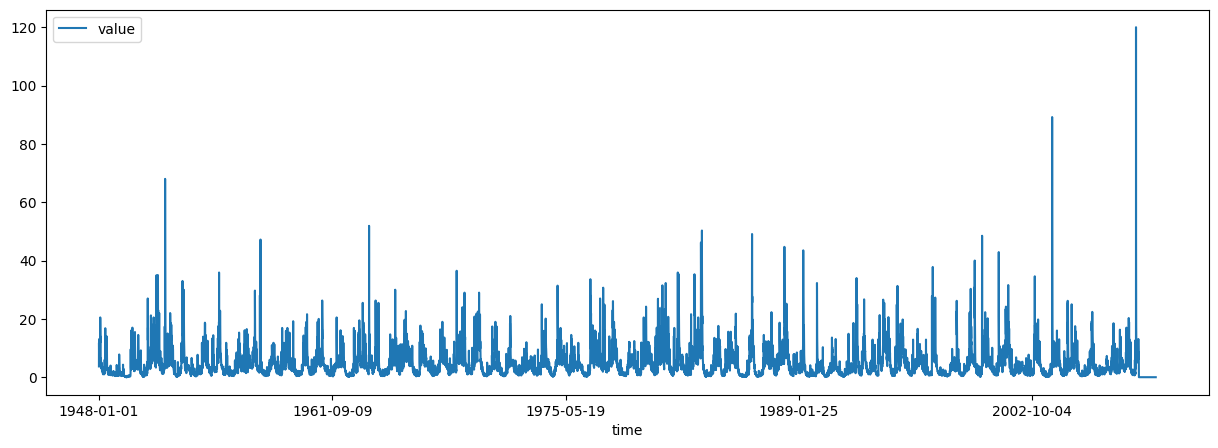

In [79]:
df.plot(x='time', y='value', figsize=(15, 5))

In [81]:
PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

In [55]:
data = df['value'].to_numpy()

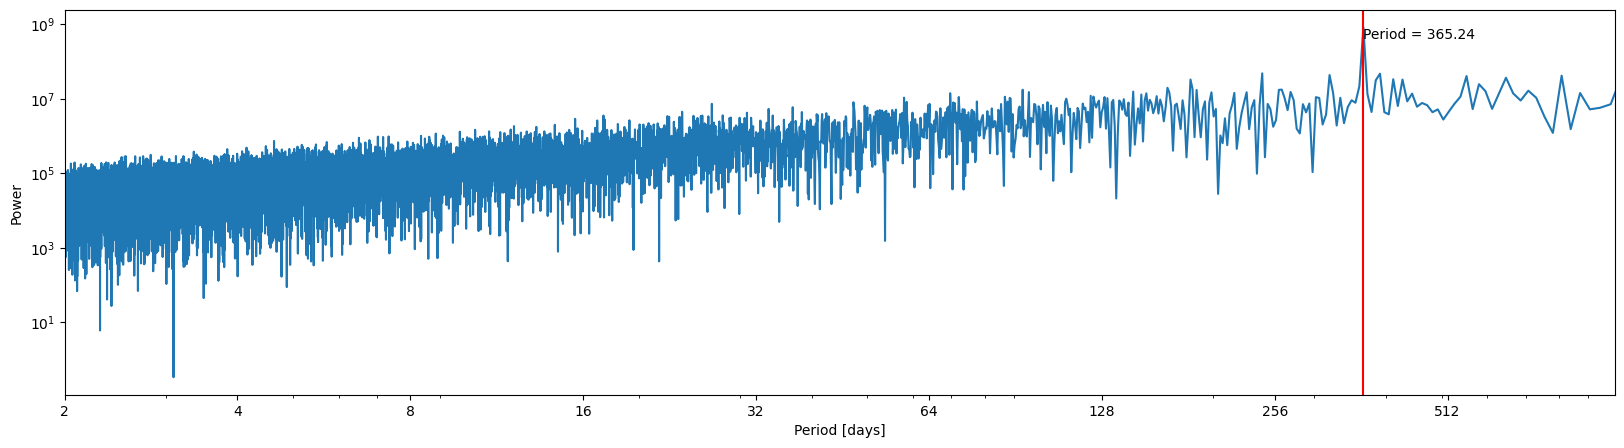

In [82]:
# Calculate the FFT
fft = np.fft.fft(data)
fft = fft[1 : len(fft) // 2]

# Calculate the power spectrum
power_spectrum = np.abs(fft) ** 2

# Calculate the frequencies
sample_freq = np.fft.fftfreq(len(data), d=1)
sample_freq = sample_freq[1 : len(sample_freq) // 2]

# Plot the power spectrum as a function of the period
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(1 / sample_freq, power_spectrum)

# Plot the highest peak in the power spectrum as a vertical line
max_period = 1 / sample_freq[np.argmax(power_spectrum)]
ax.axvline(max_period, color="red")

# Add text to this line
ax.text(
    max_period,
    0.5 * np.max(power_spectrum),
    "Period = " + str(np.round(max_period, 2))
)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_xlim(2, 1000)
plt.show()


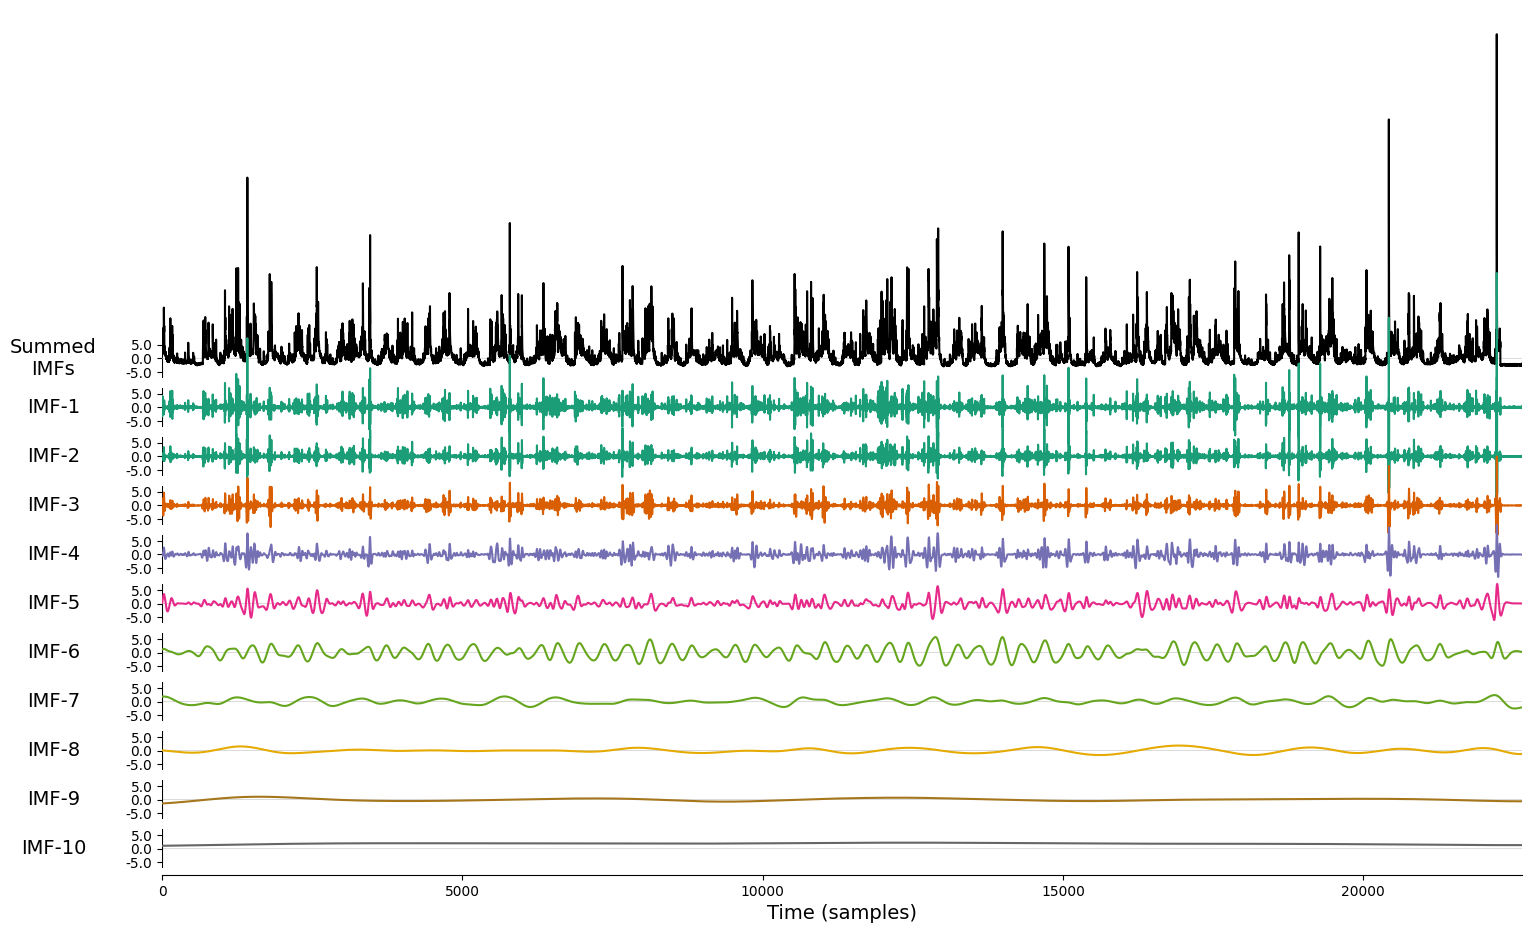

In [58]:
# Calculate the EMD
imf = emd.sift.ensemble_sift(data, max_imfs=10, nensembles=1024, nprocesses=32, ensemble_noise=1)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')